<center><img src="att/banner_mais.png"></center>

 <p style="font-family: Verdana; font-size: 12px; text-align: left; line-height: 1.8;">CPT6 | <i>Camarao, Lacson, Lugod, Militar</i></p>

<p style="font-family: Verdana; font-size: 20px; text-align: left; line-height: 1.8;">
    <b>What if we could turn <span style="color: #EA0808;">laborious manual checking</span> of diseases in cornfields...</b>
</p>

<center><img src="att/farmer_drone.png" width=800></center>

<p style="font-family: Verdana; font-size: 20px; text-align: right; line-height: 1.8;"><b>...into <span style="color: #233DFF;">automated disease detection</span> using drones?</b></p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">To turn this vision into reality, we need a <b>reliable and accurate model</b> that will be able to identify sickness in corn plants using  drone images.</p>

<center><img src="att/healthy_sick.png"></center>

<p style="font-family: Verdana; font-size: 18px; text-align: justify; line-height: 1.8;"><b>Come join me as we build this model and start revolutionizing corn disease detection with the power of deep learning!</b></p>

<h1 style="font-family:Verdana; color:#0D52BD; font-size:26px">Importing Relevant Libraries</h1>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Before getting started, let's import these libraries first!</p>

In [1]:
import os
import random
import shutil
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pytorch_grad_cam import GradCAM, AblationCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import gc

gc.collect()
torch.cuda.empty_cache()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Since we will be dealing with deep learning, having GPU access is a must (<i>for our wellbeing</i>). So let's get some sanity checks done to ensure that we do have access prior to running our models.</p>

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device is {device}.')

Device is cuda.


<h1 style="font-family:Verdana; color:#0D52BD; font-size:26px">Building the Dataset</h1>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Some helper functions will aid us in building and structuring the dataset so that it is easily accessible for the deep learning models once we train them.</p>

In [3]:
def create_directory(directory):
    """
    Create a directory if it doesn't exist.

    Parameters:
    directory (str): The directory path to create.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

def random_undersample_files(source_folder, dest_folder, count):
    """
    Randomly undersample files from the source folder and copy them to the destination folder.

    Parameters:
    source_folder (str): The path to the source folder.
    dest_folder (str): The path to the destination folder.
    count (int): The number of files to undersample.

    Note:
    This function assumes the source folder contains the files to be undersampled.
    """
    files = os.listdir(source_folder)
    random.shuffle(files)

    for file in files[:count]:
        source_path = os.path.join(source_folder, file)
        dest_path = os.path.join(dest_folder, file)
        shutil.copy(source_path, dest_path)

def balance_dataset():
    """
    Perform random undersampling for the 'healthy' and 'sick' folders.

    This function checks if the 'healthy' and 'sick' folders exist.
    If they exist, the function skips undersampling.
    Otherwise, it creates the directories, determines the lower count
    between 'all_healthy' and 'all_sick' folders, and performs random
    undersampling by copying the appropriate number of files to both folders.
    """
    folder_a = "data/healthy"
    folder_b = "data/sick"
    folder_healthy = "data/drone_images/all_healthy"
    folder_sick = "data/drone_images/all_sick"

    # Check if folder_a and folder_b exist
    if os.path.exists(folder_a) and os.path.exists(folder_b):
        print("Directories 'data/healthy' and 'data/sick' already exist. Skipping undersampling.")
        return

    # Create directories if they don't exist
    create_directory(folder_a)
    create_directory(folder_b)

    # Count the number of JPG files in the folders
    count_healthy = len([file for file in os.listdir(folder_healthy) if file.lower().endswith(".jpg")])
    count_sick = len([file for file in os.listdir(folder_sick) if file.lower().endswith(".jpg")])

    # Determine the lower count for random undersampling
    lower_count = min(count_healthy, count_sick)

    # Perform random undersampling for healthy and sick folders
    random_undersample_files(folder_healthy, folder_a, lower_count)
    random_undersample_files(folder_sick, folder_b, lower_count)

    print(f"Random undersampling complete. {lower_count} files copied to both {folder_a} and {folder_b}.")

def create_dataset(src, dst, range_):
    """Copy images within range_ from src to dst.
    
    Parameters
    ----------
    src : str
        source directory
    dst : str
        destination directory
    range_ : tuple
        tuple of min and max image index to copy
    """
    if os.path.exists(dst):
        print(f"Destination directory '{dst}' already exists. Skipping.")
        return

    os.makedirs(dst)
    fnames = os.listdir(src)
    for fname in tqdm(fnames[range_[0]: range_[1]]):
        src_file = os.path.join(src, fname)
        dst_file = os.path.join(dst, fname)
        shutil.copyfile(src_file, dst_file)

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">We will use the <a href="https://osf.io/p67rz/">Corn Image Dataset</a> from the Open Science Framework (OSF) to train our models. The dataset contains a comprehensive collection of annotated corn leaf images, focusing on lesions caused by <b>Northern Leaf Blight</b>.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Northern Leaf Blight (NLB) is a damaging maize disease caused by the fungus <u><i>Setosphaeria turcica</i></u>. It causes necrotic lesions on corn leaves, leading to yield loss and economic damage. Detecting NLB early and accurately is vital for effective disease management. Through advanced technologies like remote sensing and image analysis, we can enhance disease detection and protect corn crops from the devastating effects of NLB.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">However, the data available contains <b>more <span style="color: #EA0808;">sick</span> leaves than <span style="color: #233DFF;">healthy</span> leaves</b>, considering the photos were taken from an experimental cornfield where corn plants were intentionally inoculated with the NLB for research and documentation purposes.</p>

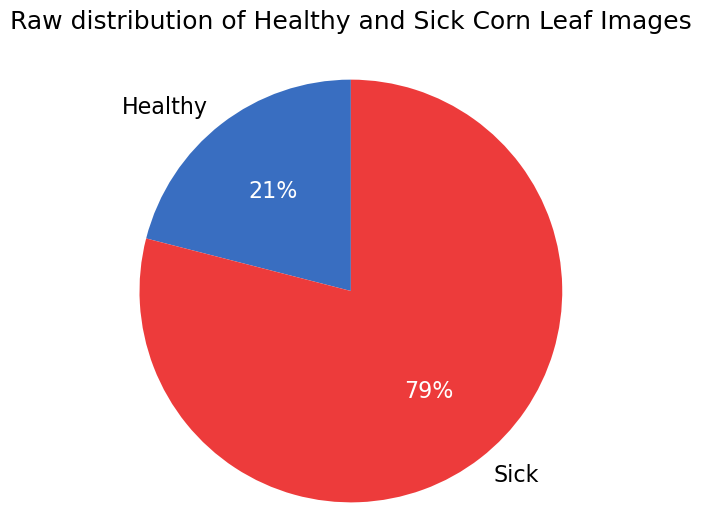

In [37]:
all_healthy_dir = 'data/drone_images/all_healthy'
all_sick_dir = 'data/drone_images/all_sick'

# Count the number of JPG files in each directory
healthy_count = len([file for file in os.listdir(all_healthy_dir) if file.lower().endswith('.jpg')])
sick_count = len([file for file in os.listdir(all_sick_dir) if file.lower().endswith('.jpg')])

# Create a pie chart
labels = ['Healthy', 'Sick']
sizes = [healthy_count, sick_count]
colors = ['#396EC1', '#ED3B3B']

plt.figure(figsize=(6, 6))
plt.title('Raw distribution of Healthy and Sick Corn Leaf Images', fontsize=18, y=1.05)

# Plot the pie chart with white font color for the percentage values
_, _, autotexts = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 16})

# Set the color of the percentage values to white
for autotext in autotexts:
    autotext.set_color('white')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show the pie chart
plt.show()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Hence, we have to balance the dataset by calling our <code>balance_dataset</code> function, which ensures that the working dataset of <span style="color: #233DFF;"><b>healthy</b></span> and <span style="color: #EA0808;"><b>sick</b></span> leaves is balanced.</p>

In [4]:
balance_dataset()

Directories 'data/healthy' and 'data/sick' already exist. Skipping undersampling.


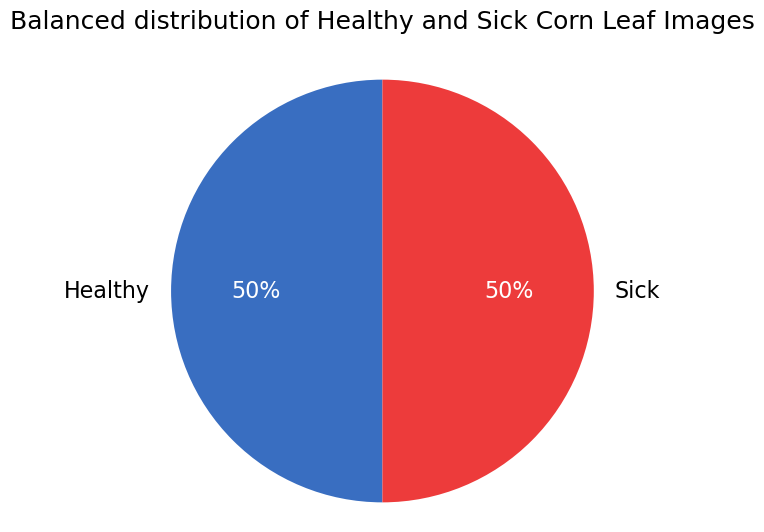

In [39]:
balanced_healthy_dir = 'data/healthy'
balanced_sick_dir = 'data/sick'

# Count the number of JPG files in each directory
healthy_count = len([file for file in os.listdir(balanced_healthy_dir) if file.lower().endswith('.jpg')])
sick_count = len([file for file in os.listdir(balanced_sick_dir) if file.lower().endswith('.jpg')])

# Create a pie chart
labels = ['Healthy', 'Sick']
sizes = [healthy_count, sick_count]
colors = ['#396EC1', '#ED3B3B']

plt.figure(figsize=(6, 6))
plt.title('Balanced distribution of Healthy and Sick Corn Leaf Images', fontsize=18, y=1.05)

# Plot the pie chart with white font color for the percentage values
_, _, autotexts = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 16})

# Set the color of the percentage values to white
for autotext in autotexts:
    autotext.set_color('white')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show the pie chart
plt.show()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Now we can start working on our balanced dataset!</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Let us just split our balanced dataset into <b>training</b>, <b>validation</b>, and <b>test</b> sets. You have to trust me wearing my data scientist hat on this, but a split of <b>70-20-10</b> will do.</p>

In [5]:
classes = ['healthy', 'sick']

# Loop through create_dataset for each class
class_counts = [len(os.listdir(os.path.join('data', class_))) for class_ in classes]  # Number of pictures for each class

for class_, count in zip(classes, class_counts):

    # Define the custom ranges for each split based on the available count
    train_range = (1, int(0.7 * count))  # 70% for training
    validation_range = (int(0.7 * count) + 1, int(0.9 * count))  # 20% for validation
    test_range = (int(0.9 * count) + 1, count)  # 10% for testing
    
    dst = f'data/train/{class_}'
    create_dataset(os.path.join('data', class_), dst, range_=train_range)

    dst = f'data/validation/{class_}'
    create_dataset(os.path.join('data', class_), dst, range_=validation_range)

    dst = f'data/test/{class_}'
    create_dataset(os.path.join('data', class_), dst, range_=test_range)

Destination directory 'data/train/healthy' already exists. Skipping.
Destination directory 'data/validation/healthy' already exists. Skipping.
Destination directory 'data/test/healthy' already exists. Skipping.
Destination directory 'data/train/sick' already exists. Skipping.
Destination directory 'data/validation/sick' already exists. Skipping.
Destination directory 'data/test/sick' already exists. Skipping.


<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">This is just to assign the filepath to our training, validation, and test sets to variables for brevity.</p>

In [6]:
data_path = Path('data')

train_dir = data_path / "train"
val_dir = data_path / "validation"
test_dir = data_path / "test"

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Let us normalize the values of the color channels (RGB) in the image for better model performance, faster convergence, and improved generalization.</p>

In [7]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transforms.Compose(
                                      [transforms.Resize((224, 224)),
                                       transforms.ToTensor()]))

if os.path.exists('pkl/all_images.pkl'):
    all_images = joblib.load('pkl/all_images.pkl')
else:
    all_images = torch.stack([img_t for img_t, _ in train_data], dim=3)
    joblib.dump(all_images, 'pkl/all_images.pkl')
means = all_images.view(3, -1).mean(dim=1).numpy()
stds = all_images.view(3, -1).std(dim=1).numpy()

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds)
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds)
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),
                                          data_transforms[x])
                  for x in ['train', 'validation', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=64,
                             shuffle=(x=='train'))
              for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

<h1 style="font-family:Verdana; color:#0D52BD; font-size:26px">Model Training and Evaluation</h1>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Now that we are finally done and over with the dataset preparation, we can finally try on a few different deep learning models to train!</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">But as the common adage goes, <b>do not reinvent the wheel</b>.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">The <code>torchvision</code> library already has <b>121 Computer Vision (CV) models</b> and even more pretrained weights for each of these models available at your fingertip. There is no need to train these models from scratch. All you have to do is call the pretrained model and stand on the shoulders of giants!</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">For our case, we will perform feature extraction on the following models:</p><br>

<b><p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">1. <a href="https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html">MobileNetV3-Large</a></p></b><br>

<center><img src="att/mnv3l.png" width="800"></center>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">This is a lightweight convolutional neural network (CNN) architecture designed for mobile and embedded devices. It introduces several innovative features, such as a combination of inverted residuals with linear bottlenecks, squeeze-and-excitation blocks for channel-wise attention, and hard-swish activation functions.</p><br>

<b><p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">2. <a href="https://pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html">ResNet-152</a></p></b><br>

<center><img src="att/resnet152.png" width="800"></center>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">This model is a deep CNN architecture that belongs to the ResNet (Residual Network) family. It is a powerful and widely used architecture that addresses the degradation problem of very deep networks by introducing residual connections. ResNet152 consists of 152 layers and utilizes residual blocks with skip connections, enabling the network to effectively learn hierarchical representations.</p><br>

<b><p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">3. <a href="https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html">VGG-19</a></p></b><br>

<center><img src="att/vgg19.png" width="800"></center>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Lastly, VGG-19 is another deep CNN architecture known for its simplicity and effectiveness. It consists of 19 layers, including convolutional layers with small 3x3 filters and max-pooling layers. VGG-19 follows a straightforward design principle of stacking multiple convolutional layers with the same filter size and using max-pooling for downsampling. This architecture excels at capturing local image features and has been widely used as a baseline or feature extractor in many computer vision tasks.</p><br>

In [9]:
model_file_paths = {'mnv3l': 'ptm/corn_model_mnv3l.pt',
                    'resnet152': 'ptm/corn_model_resnet152.pt',
                    'vgg19': 'ptm/corn_model_vgg19.pt'}

<h2 style="font-family:Verdana; color:#ED3B3B; font-size:22px">MobileNetV3-Large</h2>

Trained model found. Loading trained MobileNetV3-Large model...

Accuracy: 82.50
Precision: 100.00
Recall: 65.00
F1 Score: 78.79


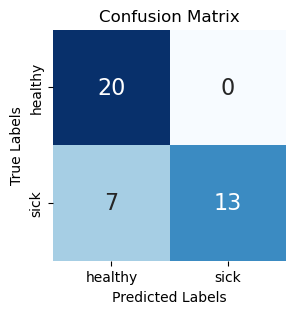

In [10]:
# Check if the model file exists
model_fpath = model_file_paths['mnv3l']

if os.path.exists(model_fpath):
    
    # Load the existing model
    model_mnv3l = models.mobilenet_v3_large(weights=None)
    num_classes = len(class_names)
    model_mnv3l.classifier = nn.Linear(in_features=960, out_features=num_classes, bias=True)
    print('Trained model found. Loading trained MobileNetV3-Large model...')

else:
    
    print('No trained model found. Training MobileNetV3-Large model...')
    # Perform training
    
    # Empty the GPU memory cache
    torch.cuda.empty_cache()

    # Define data loaders
    train_loader = dataloaders['train']
    valid_loader = dataloaders['validation']
    test_loader = dataloaders['test']

    # Load the pretrained MobileNetV3-Large model
    model_mnv3l = models.mobilenet_v3_large(pretrained=True)

    # Freeze the parameters of the pretrained layers
    for param in model_mnv3l.parameters():
        param.requires_grad = False

    # Modify the last fully connected layer to match the number of classes
    num_classes = len(class_names)
    model_mnv3l.classifier = nn.Linear(in_features=960, out_features=num_classes, bias=True)

    # Move the model to the appropriate device
    model_mnv3l = model_mnv3l.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_mnv3l.parameters(), lr=0.001)

    # Train the model
    num_epochs = 20
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        # Training
        model_mnv3l.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model_mnv3l(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # Validation
        model_mnv3l.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model_mnv3l(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        # Save the best model based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_mnv3l.state_dict(), model_fpath)

# Test the model
model_mnv3l.load_state_dict(torch.load(model_file_paths['mnv3l']))
model_mnv3l = model_mnv3l.to(device)
model_mnv3l.eval()
predictions = []
true_labels = []

test_loader = dataloaders['test']

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_mnv3l(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy_mnv3l = accuracy_score(true_labels, predictions)
precision_mnv3l = precision_score(true_labels, predictions)
recall_mnv3l = recall_score(true_labels, predictions)
f1_mnv3l = f1_score(true_labels, predictions)

print(f"\nAccuracy: {accuracy_mnv3l * 100:.2f}")
print(f"Precision: {precision_mnv3l * 100:.2f}")
print(f"Recall: {recall_mnv3l * 100:.2f}")
print(f"F1 Score: {f1_mnv3l * 100:.2f}")

# Confusion matrix
conf_matrix_mnv3l = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_mnv3l, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"fontsize": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">100% precision? <b>Wow!</b></p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">While that may sound incredible to the uninitiated, the poor recall will give away the poor performance of this model. What the high precision and poor recall mean is that the model only classified images it was confident enough to classify as sick. So everything it classified as sick was actually sick, but it decided not to even attempt to classify as sick other images that were less obvious to be sick. In common parlance, this model is <i>too conservative</i>.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Should this model be implemented in the real world, it would almost never misdiagnose any corn plants as sick but end up missing a lot of actually sick corn plants. This will greatly increase the potential for undetected and uncontrolled disease propagation within the cornfield.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;"><b><i>A farmer's nightmare!</i></b></p>

<h2 style="font-family:Verdana; color:#ED3B3B; font-size:22px">ResNet-152</h2>

Trained model found. Loading trained ResNet-152 model...

Accuracy: 80.00
Precision: 83.33
Recall: 75.00
F1 Score: 78.95


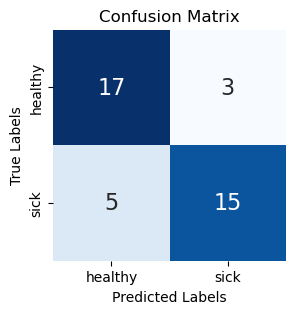

In [11]:
# Check if the model file exists
model_fpath = model_file_paths['resnet152']

if os.path.exists(model_fpath):
    
    # Load the existing model
    model_resnet152 = models.resnet152(weights=None)
    num_classes = len(class_names)
    model_resnet152.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    print('Trained model found. Loading trained ResNet-152 model...')

else:
    
    print('No trained model found. Training ResNet-152 model...')
    # Perform training

    # Empty the GPU memory cache
    torch.cuda.empty_cache()

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define data loaders
    train_loader = dataloaders['train']
    valid_loader = dataloaders['validation']
    test_loader = dataloaders['test']

    # Load the pretrained ResNet152 model
    model_resnet152 = models.resnet152(pretrained=True)

    # Freeze the parameters of the pretrained layers
    for param in model_resnet152.parameters():
        param.requires_grad = False

    # Modify the last fully connected layer to match the number of classes
    num_classes = len(class_names)
    model_resnet152.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)

    # Move the model to the appropriate device
    model_resnet152 = model_resnet152.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_resnet152.parameters(), lr=0.01)

    # Train the model
    num_epochs = 20
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        # Training
        model_resnet152.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model_resnet152(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # Validation
        model_resnet152.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model_resnet152(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        # Save the best model based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_resnet152.state_dict(), model_fpath)

# Test the model
model_resnet152.load_state_dict(torch.load(model_file_paths['resnet152']))
model_resnet152 = model_resnet152.to(device)
model_resnet152.eval()
predictions = []
true_labels = []

test_loader = dataloaders['test']

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_resnet152(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy_resnet152 = accuracy_score(true_labels, predictions)
precision_resnet152 = precision_score(true_labels, predictions)
recall_resnet152 = recall_score(true_labels, predictions)
f1_resnet152 = f1_score(true_labels, predictions)

print(f"\nAccuracy: {accuracy_resnet152 * 100:.2f}")
print(f"Precision: {precision_resnet152 * 100:.2f}")
print(f"Recall: {recall_resnet152 * 100:.2f}")
print(f"F1 Score: {f1_resnet152 * 100:.2f}")

# Confusion matrix
conf_matrix_resnet152 = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_resnet152, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"fontsize": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">This model achieved much lower precision than MobileNet but a higher recall. Overall, this ResNet-152 model performs better than the previous model. However, we can possibly try another model and get both higher precision and recall.</p>

<h2 style="font-family:Verdana; color:#ED3B3B; font-size:22px">VGG-19</h2>

Trained model found. Loading trained VGG-19 model...

Accuracy: 90.00
Precision: 86.36
Recall: 95.00
F1 Score: 90.48


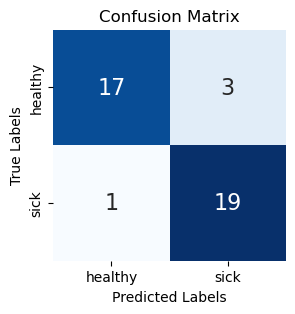

In [12]:
# Check if the model file exists
model_fpath = model_file_paths['vgg19']

if os.path.exists(model_fpath):
    
    # Load the existing model
    model_vgg19 = models.vgg19(weights=None)
    num_classes = len(class_names)
    model_vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
    print('Trained model found. Loading trained VGG-19 model...')

else:
    
    print('No trained model found. Training VGG-19 model...')
    # Perform training

    # Empty the GPU memory cache
    torch.cuda.empty_cache()

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define data loaders
    train_loader = dataloaders['train']
    valid_loader = dataloaders['validation']
    test_loader = dataloaders['test']

    # Load the pretrained VGG-19 model
    model_vgg19 = models.vgg19(pretrained=True)

    # Freeze the parameters of the pretrained layers
    for param in model_vgg19.parameters():
        param.requires_grad = False

    # Modify the last fully connected layer to match the number of classes
    num_classes = len(class_names)
    model_vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    # Move the model to the appropriate device
    model_vgg19 = model_vgg19.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_vgg19.parameters(), lr=0.001)

    # Train the model
    num_epochs = 20
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        # Training
        model_vgg19.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model_vgg19(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # Validation
        model_vgg19.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model_vgg19(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        # Save the best model based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_vgg19.state_dict(), model_fpath)

# Test the model
model_vgg19.load_state_dict(torch.load(model_file_paths['vgg19']))
model_vgg19 = model_vgg19.to(device)
model_vgg19.eval()
predictions = []
true_labels = []

test_loader = dataloaders['test']

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_vgg19(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy_vgg19 = accuracy_score(true_labels, predictions)
precision_vgg19 = precision_score(true_labels, predictions)
recall_vgg19 = recall_score(true_labels, predictions)
f1_vgg19 = f1_score(true_labels, predictions)

print(f"\nAccuracy: {accuracy_vgg19 * 100:.2f}")
print(f"Precision: {precision_vgg19 * 100:.2f}")
print(f"Recall: {recall_vgg19 * 100:.2f}")
print(f"F1 Score: {f1_vgg19 * 100:.2f}")

# Confusion matrix
conf_matrix_vgg19 = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_vgg19, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"fontsize": 16})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;"><b>Voila!</b></p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Using the VGG-19 model, we achieved much higher precision and recall for our test set. Looking at the confusion matrix, for every 20 actually <span style="color: #233DFF;">healthy</span> corn leaves, only 3 were misidentified! To make it even better, for every 20 <span style="color: #EA0808;">sick</span> corn leaves, <b>only one</b> was not detected by the model.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">If the best model among the three is not obvious enough, let us compare the performance of the three models and justify our choice!</p>

<h1 style="font-family:Verdana; color:#0D52BD; font-size:26px">Model Selection</h1>

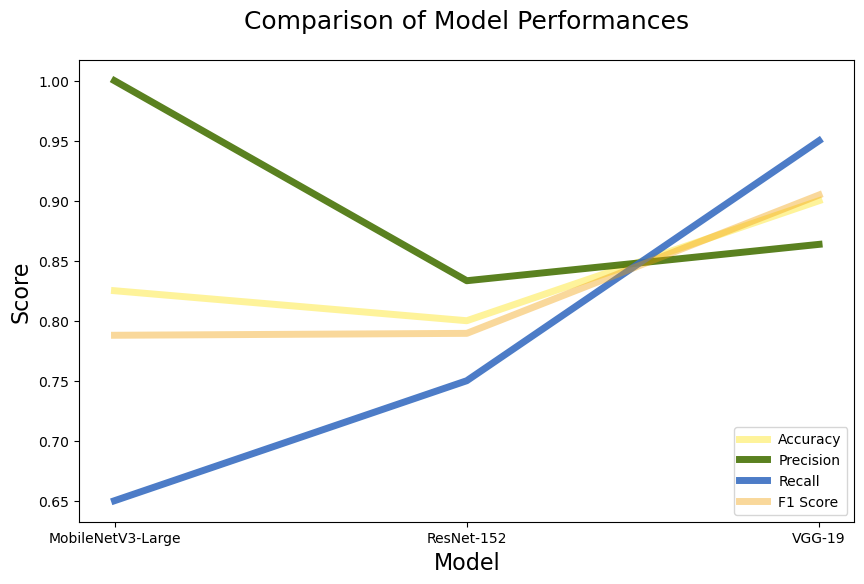

In [13]:
df_models = pd.DataFrame([[accuracy_mnv3l, precision_mnv3l, recall_mnv3l, f1_mnv3l],
                          [accuracy_resnet152, precision_resnet152, recall_resnet152, f1_resnet152],
                          [accuracy_vgg19, precision_vgg19, recall_vgg19, f1_vgg19]],
                         index=['MobileNetV3-Large', 'ResNet-152', 'VGG-19'],
                         columns=['Accuracy', 'Precision', 'Recall', 'F1 Score']
                        )

# Create a DataFrame with row indices as x-axis values
df = df_models.reset_index()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the lines for accuracy, precision, recall, and f1 score
sns.lineplot(data=df, x='index', y='Accuracy', label='Accuracy',
             color='#FEE103', linewidth=5, alpha=0.4, ax=ax)
sns.lineplot(data=df, x='index', y='Precision', label='Precision',
             color='#487307', linewidth=5, alpha=0.9, ax=ax)
sns.lineplot(data=df, x='index', y='Recall', label='Recall',
             color='#396EC1', linewidth=5, alpha=0.9, ax=ax)
sns.lineplot(data=df, x='index', y='F1 Score', label='F1 Score',
             color='#F29F05', linewidth=5, alpha=0.4, ax=ax)

# Set the labels and title
ax.set_xlabel('Model', fontsize=16)
ax.set_ylabel('Score', fontsize=16)
ax.set_title('Comparison of Model Performances', fontsize=18, y=1.05)

# Show the legend
ax.legend()

# Show the plot
plt.show()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Quite obviously, we shall go with the VGG-19 model among the three deep learning models we considered. The VGG-19 model gives us the best of the four worlds of <span style="color: #FEE103;"><b><i>accuracy</i></b></span>, <span style="color: #487307;"><b><i>precision</i></b></span>, <span style="color: #396EC1;"><b><i>recall</i></b></span>, and <span style="color: #F29F05;"><b><i>F1 score</i></b></span>.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">This high <span style="color: #487307;">precision</span> translates to more efficient operations in the corn fields, bigger cost savings, and a more optimized farmer workload. Because fewer healthy corn leaves will be misdiagnosed by the model as sick, there will be considerably less need for farmers to manually verify misdiagnosed corn leaves. This will have the potential to increase profit margins significantly.</p> 

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Furthermore, this high <span style="color: #396EC1;">recall</span> means that more corn plants are healthy, safe, and protected from infectious and devastating diseases. Safe and healthy corn plants lead to financial and job security for the farmers, ensuring that they get to eat and live another day.</p>

<center><img src="att/corn_farmers.png" width="480"></center>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Given that capital and lives are at stake...</p><br>
    
<p style="font-family: Verdana; font-size: 20px; text-align: center; line-height: 1.8;"><b>How do we know if we can trust the predictions of the model?</b></p><br>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">How can we even know how the model makes its predictions?</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">That's where <b>explainable AI (XAI)</b> comes in!</p>

<h1 style="font-family:Verdana; color:#0D52BD; font-size:26px">Explainable AI</h1>

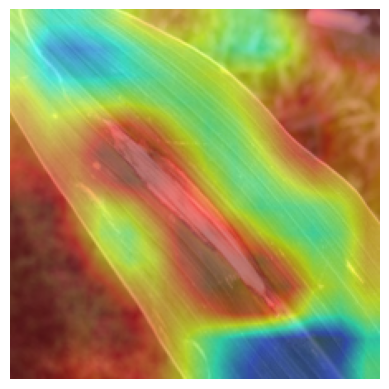

In [43]:
image_path = os.path.join('data/cam/lesion_1.png')
image = Image.open(image_path)
image = image.convert("RGB")
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds),
])

# Preprocess the image
input_tensor = preprocess(image)

# Add a batch dimension
input_tensor = input_tensor.unsqueeze(0)

torch.cuda.empty_cache()
model_cam = models.vgg19(weights=None)
model_cam.classifier[6] = nn.Linear(4096, len(class_names))
model_cam = model_cam.to('cuda')
model_cam.load_state_dict(torch.load('ptm/corn_model_vgg19_2.pt'))
model_cam.eval()

target_layers = [model_cam.features[34]] # Last Conv2d layer
targets = [ClassifierOutputTarget(0)] # Class 'sick'

# Show the GradCAM overlay
gradcam = GradCAM(model=model_cam, target_layers=target_layers, use_cuda=True)
gradcam_grayscale_cam = gradcam(input_tensor=input_tensor, targets=targets)
gradcam_grayscale_cam = gradcam_grayscale_cam[0]
plt.imshow(show_cam_on_image(original_image, gradcam_grayscale_cam))
plt.axis('off')
plt.show()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;"><b>Explainable AI (XAI)</b> allows us to visualize which parts of the image the model gives greater importance to when it makes its predictions. In our case, having XAI validates our intuition that the model does indeed <i>look at the lesions</i> on the leaves when it makes its predictions. The red areas in the image of the leaves highlight which parts contributed positively to the model's prediction that the leaf is sick, while the blue regions correspond to areas that did not help in identifying the leaf as sick.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Basically, XAI shows us that it looks at the <b>right</b> areas and features of the leaves when it makes its predictions about whether the leaf is healthy or sick and that the excellent performance is not simply due to questionable luck.</p>

100%|██████████| 16/16 [00:01<00:00, 14.66it/s]


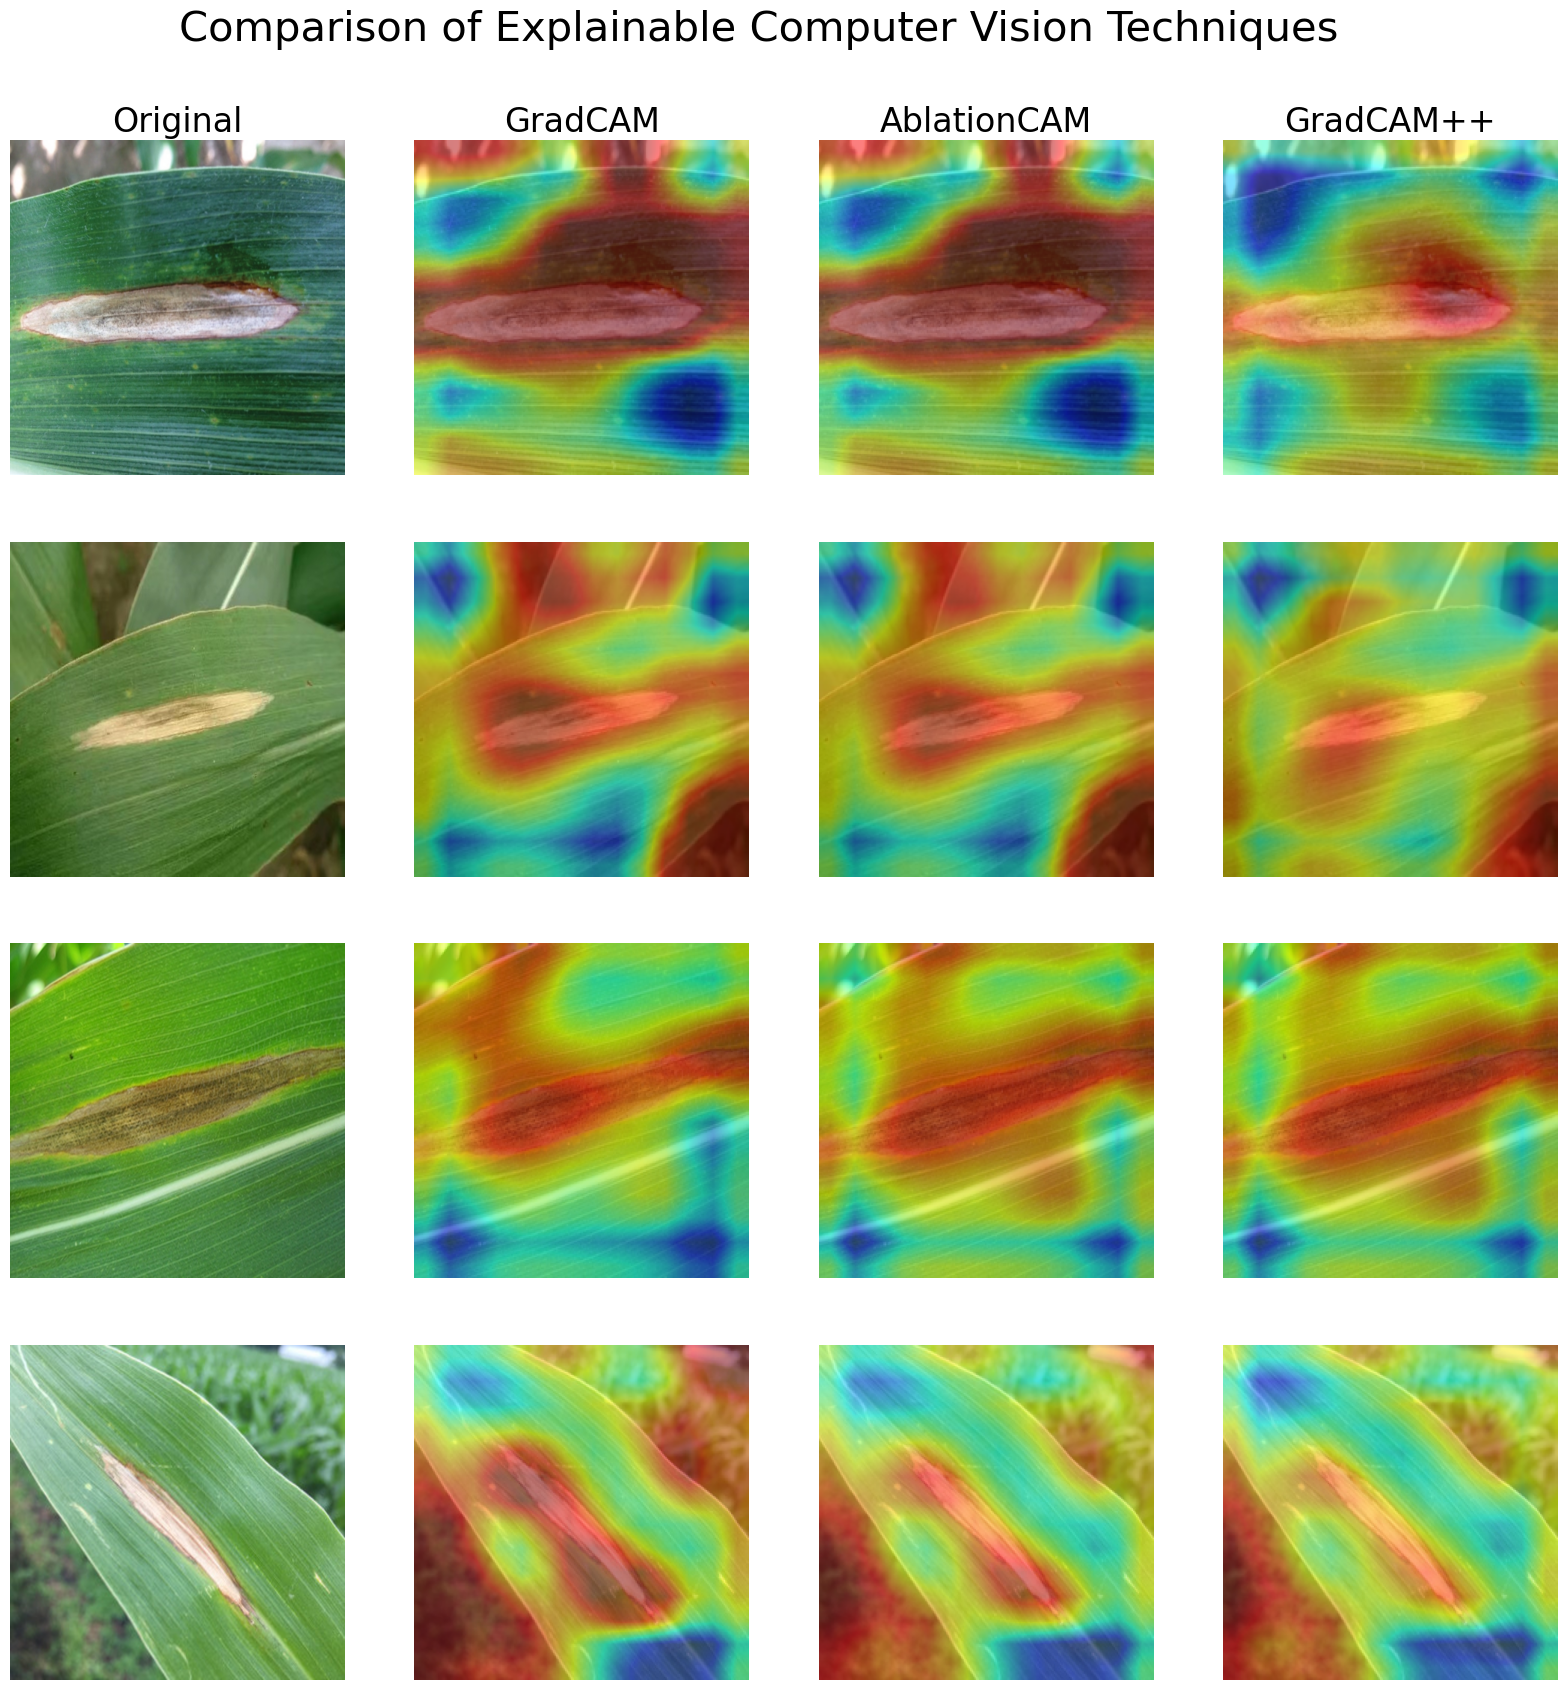

In [14]:
cam_imgs = [file for file in os.listdir('data/cam') if file.lower().endswith('.png')]

fig, ax = plt.subplots(len(cam_imgs), 4, figsize=(20, 20))
plt.suptitle('Comparison of Explainable Computer Vision Techniques', fontsize=30, y=0.945)

for i, img_name in enumerate(cam_imgs):

    image_path = os.path.join('data/cam', img_name)
    image = Image.open(image_path)
    image = image.convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds),
    ])

    # Preprocess the image
    input_tensor = preprocess(image)

    # Add a batch dimension
    input_tensor = input_tensor.unsqueeze(0)

    # Now we load and resize the original image for display purposes
    original_image = np.array(image.resize((224, 224)), dtype=np.float32) / 255
    large_orig = np.array(image.resize((2000, 2000)), dtype=np.float32) / 255
    
    # Show the original image
    ax[i][0].imshow(large_orig)
    if i==0:
        ax[i][0].set_title('Original', fontsize=24)
    ax[i][0].axis('off')

    # Show the GradCAM overlay
    gradcam = GradCAM(model=model_cam, target_layers=target_layers, use_cuda=True)
    gradcam_grayscale_cam = gradcam(input_tensor=input_tensor, targets=targets)
    gradcam_grayscale_cam = gradcam_grayscale_cam[0]
    ax[i][1].imshow(show_cam_on_image(original_image, gradcam_grayscale_cam))
    if i==0:
        ax[i][1].set_title('GradCAM', fontsize=24)
    ax[i][1].axis('off')
    
    # Show the AblationCAM overlay
    torch.cuda.empty_cache()
    ablationcam = AblationCAM(model=model_cam, target_layers=target_layers, use_cuda=True)
    ablationcam_grayscale_cam = ablationcam(input_tensor=input_tensor, targets=targets)
    ablationcam_grayscale_cam = ablationcam_grayscale_cam[0]
    ax[i][2].imshow(show_cam_on_image(original_image, ablationcam_grayscale_cam))
    if i==0:
        ax[i][2].set_title('AblationCAM', fontsize=24)
    ax[i][2].axis('off')
    
    # Show the GradCAM++ overlay
    torch.cuda.empty_cache()
    gradcamplusplus = GradCAMPlusPlus(model=model_cam, target_layers=target_layers, use_cuda=True)
    gradcamplusplus_grayscale_cam = gradcamplusplus(input_tensor=input_tensor, targets=targets)
    gradcamplusplus_grayscale_cam = gradcamplusplus_grayscale_cam[0]
    ax[i][3].imshow(show_cam_on_image(original_image, gradcamplusplus_grayscale_cam))
    if i==0:
        ax[i][3].set_title('GradCAM++', fontsize=24)
    ax[i][3].axis('off')

fig.show()

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;"><b>GradCAM</b> highlights the important regions by computing the gradients of the target class with respect to the convolutional feature maps. It then combines these gradients to obtain a heatmap, indicating the regions of the image that are most influential for the prediction.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;"><b>AblationCAM</b> takes the process further by iteratively removing (<i>ablating</i>) portions of the image and observing the impact on the prediction confidence. By systematically ablating different regions, it identifies the critical areas that significantly affect the prediction.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;"><b>GradCAM++</b> builds upon GradCAM by incorporating higher-order gradients to capture more detailed information about the importance of each pixel. It enhances localization accuracy by considering both positive and negative gradients.</p>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Aside from these three, there are a multitude of other XAI libraries out there, each with their own <i>pros</i> and <i>cons</i> depending on your use case. In our case, even vanilla GradCAM can do the job of explaining and validating our intuitions quite well and reliably.</p>

<center><img src="att/fly_drone.jpeg" ></center>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Here lies in our reach the potential to ensure that each and every corn plant out there in the fields is healthy, safe, and protected—one plant at a time.</p><br>

<p style="font-family: Verdana; font-size: 16px; text-align: justify; line-height: 1.8;">Together, we can rewrite the story of farming.</p><br><br>

<p style="font-family: Verdana; font-size: 18px; text-align: center; line-height: 2.0;"><b>With drone technology, deep learning, and explainable AI, we can ensure a future where every plant thrives and every farmer's dream becomes a reality.</b></p>

<h1 style="font-family:Verdana; color:#0D52BD; font-size:26px">References</h1>

<p style="font-family: Verdana; font-size: 12px; text-align: left; line-height: 1.8;">[1] Bustamante, C. (n.d.). <i>Family members manually shelling corn in Bukidnon</i>. Institute of Environmental Science for Social Change. photograph. Retrieved from https://essc.org.ph/content/wp-content/uploads/2018/09/2018_09_19_LUCID-Story5_Photo1.jpg.</p>

<p style="font-family: Verdana; font-size: 12px; text-align: left; line-height: 1.8;">[2] <i>Colourful different fruits pattern</i>. (n.d.-b). Freepik. photograph. Retrieved from https://www.freepik.com/free-vector/colourful-different-fruits-pattern_9002480.htm#query=fruit%20pattern&amp;position=5&amp;from_view=keyword&amp;track=ais.</p> 

<p style="font-family: Verdana; font-size: 12px; text-align: left; line-height: 1.8;">[3] Gildenblat, J. (n.d.). <i>Advanced AI explainability with Pytorch-gradcam</i>. Introduction: Advanced Explainable AI for computer vision - Advanced AI explainability with pytorch-gradcam. https://jacobgil.github.io/pytorch-gradcam-book/introduction.html.</p>